In [1]:
%matplotlib widget

# Use a ML algorithm to estimate a 2 layered EC model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
#from mpl_toolkits import mplot3d
import pandas as pd
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from keras.optimizers import SGD
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

import pathlib
import shutil
import tempfile

import sys
sys.path.insert(1, '../../src')

from PlotModel import Plot3Models_2lay

2023-08-22 16:07:21.193541: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-22 16:07:21.288172: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-22 16:07:21.289529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 16:07:22.994467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Upload some things

data_true = np.load('../data/data_true.npy')
model = np.load('../data/model_true.npy')
model_est = np.load('../data/model_est.npy')
conds = np.load('../data/conds_samples.npy')
data_true_noise = np.load('../data/data_true_noise.npy')
model_est_noise = np.load('../data/model_est_noise.npy')


In [4]:
# Input variables conds and thicks must be in a single array X
# The lookup table is the output variables stored as array Y
# Y = f(X)

X = np.load('../data/models.npy')
Y = np.load('../data/LookupTable2Layers.npy')

dataset = pd.DataFrame(np.hstack((X,Y)), 
                       columns=['sigm1', 'sigm2', 'thick1', 
                                'Q_H_2','Q_H_4','Q_H_8',
                                'Q_V_2','Q_V_4','Q_V_8',
                                'Q_P_2.1','Q_P_4.1','Q_P_8.1',
                                'IP_H_2','IP_H_4','IP_H_8',
                                'IP_V_2','IP_V_4','IP_V_8',
                                'IP_P_2.1','IP_P_4.1','IP_P_8.1'])

## Extract a training and testing dataset

In [5]:
train_dataset = dataset.sample(frac=0.6, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
test_dataset = test_dataset.sample(frac=0.2, random_state=0)

In [6]:
# Inspect the statistics

train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sigm1,79591.0,0.152567,0.242367,1.000000e-03,0.005248,0.031623,0.190546,1.000000
sigm2,79591.0,0.151921,0.240962,1.000000e-03,0.005248,0.031623,0.190546,1.000000
thick1,79591.0,3.550811,2.031197,1.000000e-01,1.756000,3.550000,5.344000,7.000000
Q_H_2,79591.0,0.008188,0.010511,6.973544e-05,0.001013,0.003382,0.011154,0.044603
Q_H_4,79591.0,0.023603,0.024850,2.763871e-04,0.004151,0.013362,0.036077,0.094159
Q_H_8,79591.0,0.040109,0.029393,1.405267e-05,0.012698,0.035735,0.064966,0.106808
Q_V_2,79591.0,0.008494,0.011815,6.381996e-05,0.000820,0.002929,0.011032,0.051037
Q_V_4,79591.0,0.031034,0.039629,2.665653e-04,0.003946,0.013011,0.042332,0.168932
Q_V_8,79591.0,0.094166,0.101841,1.079073e-03,0.016870,0.052162,0.139713,0.406256
Q_P_2.1,79591.0,0.010504,0.015384,7.084164e-05,0.000735,0.003137,0.013294,0.066750


## Splitting features and labels

In [7]:
# Split features and labels

train_features = train_dataset.reindex(columns = ['Q_H_2','Q_H_4','Q_H_8',
                                'Q_V_2','Q_V_4','Q_V_8',
                                'Q_P_2.1','Q_P_4.1','Q_P_8.1',
                                'IP_H_2','IP_H_4','IP_H_8',
                                'IP_V_2','IP_V_4','IP_V_8',
                                'IP_P_2.1','IP_P_4.1','IP_P_8.1'])
test_features = test_dataset.reindex(columns = ['Q_H_2','Q_H_4','Q_H_8',
                                'Q_V_2','Q_V_4','Q_V_8',
                                'Q_P_2.1','Q_P_4.1','Q_P_8.1',
                                'IP_H_2','IP_H_4','IP_H_8',
                                'IP_V_2','IP_V_4','IP_V_8',
                                'IP_P_2.1','IP_P_4.1','IP_P_8.1'])

train_labels = train_dataset.reindex(columns= ['sigm1', 'sigm2', 'thick1'])
test_labels = test_dataset.reindex(columns=['sigm1', 'sigm2', 'thick1'])


In [8]:
# Normalize dataset

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[0.00818758 0.02360281 0.04010924 0.00849371 0.03103362 0.09416609
  0.01050402 0.03931176 0.12558189 0.00207251 0.01259135 0.05572445
  0.00112932 0.00761894 0.04292719 0.0007206  0.00676412 0.05121319]]


In [9]:
#When the layer is called, it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1])

with np.printoptions(precision=5, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[0.00337 0.00689 0.01359 0.00461 0.01401 0.03743 0.00603 0.01722 0.04317
  0.00011 0.00065 0.00367 0.00006 0.0004  0.0024  0.00004 0.00029 0.00185]]

Normalized: [[-0.45854 -0.67258 -0.90233 -0.32884 -0.42948 -0.5571  -0.29063 -0.41483
  -0.58122 -0.56621 -0.61322 -0.73516 -0.55217 -0.57923 -0.63755 -0.46507
  -0.50143 -0.57105]]


# Using a DNN

In [10]:
def build_and_compile_model(norm):
    model = Sequential([
      norm,
      layers.Dense(32, activation='softmax' ),
      layers.Dense(32, activation='softmax' ),
      layers.Dense(3, ) # added a non neg constraint, will it work? tf.keras.constraints.NonNeg()
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [11]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 18)                37        
 on)                                                             
                                                                 
 dense (Dense)               (None, 32)                608       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1800 (7.04 KB)
Trainable params: 1763 (6.89 KB)
Non-trainable params: 37 (152.00 Byte)
_________________________________________________________________


In [12]:
startTime = time.time()
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)
endTime = time.time() - startTime
print('Training time:', endTime/60, 'min')

Training time: 323.843576669693


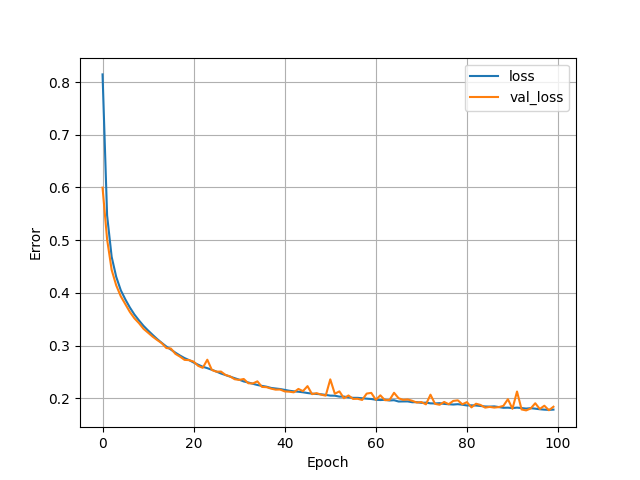

In [15]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

In [16]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

{'dnn_model': 0.18221522867679596}

In [17]:
test_predictions = dnn_model.predict(test_features)

332/332 [==============================] - 0s 996us/step


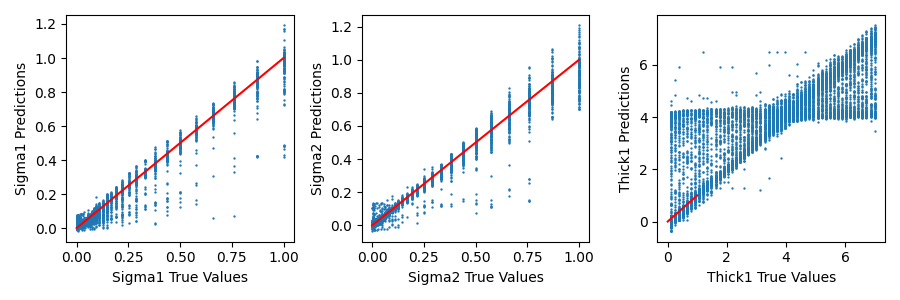

In [18]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

ax[0].scatter(np.array(test_labels)[:,0], test_predictions[0:,0], s= 0.5)
ax[0].plot([0,1],[0,1], 'r')
ax[0].set_xlabel('Sigma1 True Values')
ax[0].set_ylabel('Sigma1 Predictions')

ax[1].scatter(np.array(test_labels)[:,1], test_predictions[0:,1], s=0.5)
ax[1].plot([0,1],[0,1], 'r')
ax[1].set_xlabel('Sigma2 True Values')
ax[1].set_ylabel('Sigma2 Predictions')

ax[2].scatter(np.array(test_labels)[:,2], test_predictions[0:,2], s=0.5)
ax[2].plot([0,1],[0,1], 'r')
ax[2].set_xlabel('Thick1 True Values')
ax[2].set_ylabel('Thick1 Predictions')

plt.tight_layout()

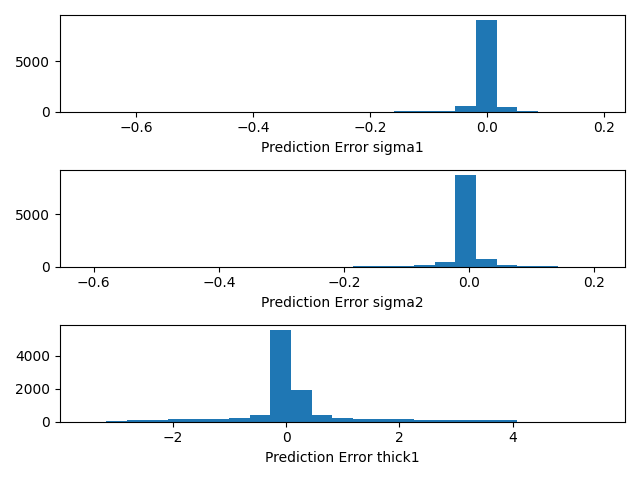

In [19]:
fig, ax = plt.subplots(3,1)
error = test_predictions - np.array(test_labels)
ax[0].hist(error[:,0], bins=25)
ax[1].hist(error[:,1], bins=25)
ax[2].hist(error[:,2], bins=25)
ax[0].set_xlabel('Prediction Error sigma1')
ax[1].set_xlabel('Prediction Error sigma2')
ax[2].set_xlabel('Prediction Error thick1')

plt.tight_layout()

## Use DNN to predict stitched 2D section

In [20]:
# Predict a model using the DNN

model_pred = dnn_model.predict(data_true)

1/1 [==============================] - 0s 58ms/step


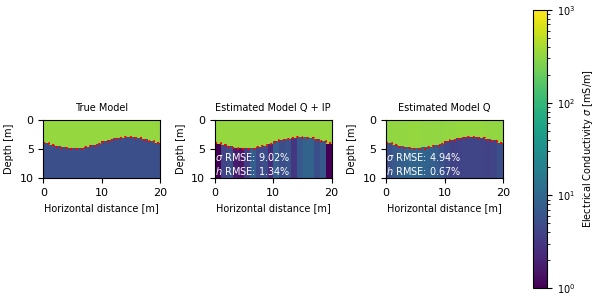

In [21]:
# The model to the right is the predicted model using DNN

Plot3Models_2lay(model, model_est, model_pred, conds)

In [22]:
# Predict a model using the DNN with noisy data

model_pred_noise = dnn_model.predict(data_true_noise)

1/1 [==============================] - 0s 14ms/step


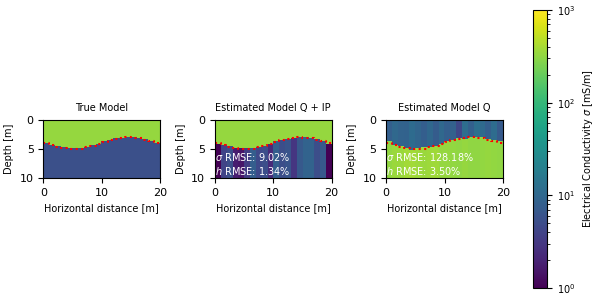

In [23]:
# The model to the right is the predicted model using DNN

Plot3Models_2lay(model, model_est, model_pred_noise, conds)

### Check if there is overfit

the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.

In other words, your model would overfit to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the training set, what you really want is to develop models that generalize well to a testing set (or data they haven't seen before).

In [24]:
N_TRAIN = len(train_dataset)
BATCH_SIZE = 2000
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

# The code above sets a tf.keras.optimizers.schedules.InverseTimeDecay to hyperbolically decrease
# the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.

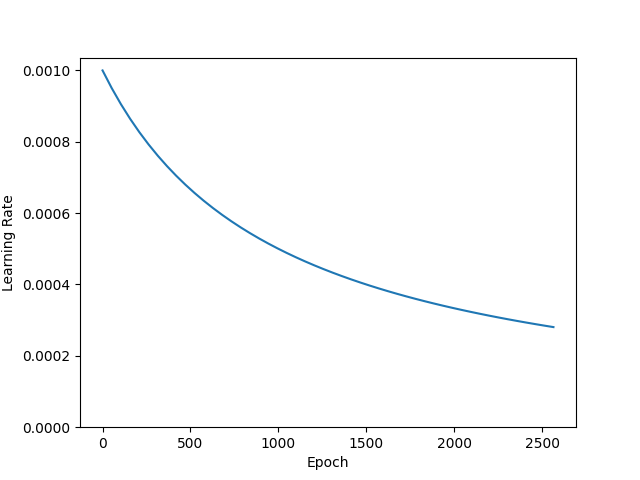

In [25]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure()
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

Next include `tf.keras.callbacks.EarlyStopping` to avoid long and unnecessary training times. 

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.

In [26]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [27]:
def get_callbacks(name):
    return [
   # tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [28]:
def compile_and_fit(model, name, optimizer=None, max_epochs=500):
    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(loss='mean_absolute_error',
                optimizer=optimizer)

    model.summary()

    history = model.fit(
        train_features,
        train_labels,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_split=0.2,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [29]:
size_histories = {}

Tiny_model = Sequential([
      normalizer,
      layers.Dense(18, activation='softmax'),
      layers.Dense(3)
    ])

startTime = time.time()
size_histories['Tiny'] = compile_and_fit(Tiny_model, 'Tiny')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 18)                37        
 on)                                                             
                                                                 
 dense_3 (Dense)             (None, 18)                342       
                                                                 
 dense_4 (Dense)             (None, 3)                 57        
                                                                 
Total params: 436 (1.71 KB)
Trainable params: 399 (1.56 KB)
Non-trainable params: 37 (152.00 Byte)
_________________________________________________________________


In [30]:
endTime = time.time() - startTime
print('Training time:', endTime/60, 'min')

Training time: 6.445656343301137 min


In [31]:
# Repeat for several sizes 

Medium_model = Sequential([
      normalizer,
      layers.Dense(36, activation='softmax'),
      layers.Dense(36, activation='softmax'),
      layers.Dense(3)
    ])

startTime = time.time()
size_histories['Medium'] = compile_and_fit(Medium_model, 'Medium')
endTime = time.time() - startTime
print('Training time:', endTime)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 18)                37        
 on)                                                             
                                                                 
 dense_5 (Dense)             (None, 36)                684       
                                                                 
 dense_6 (Dense)             (None, 36)                1332      
                                                                 
 dense_7 (Dense)             (None, 3)                 111       
                                                                 
Total params: 2164 (8.46 KB)
Trainable params: 2127 (8.31 KB)
Non-trainable params: 37 (152.00 Byte)
_________________________________________________________________
Training time: 370.0807545185089


In [32]:
Normal_model = Sequential([
      normalizer,
      layers.Dense(72, activation='softmax'),
      layers.Dense(72, activation='softmax'),
      layers.Dense(72, activation='softmax'),
      layers.Dense(3)
    ])

startTime = time.time()
size_histories['Normal'] = compile_and_fit(Normal_model, 'Normal')
endTime = time.time() - startTime
print('Training time:', endTime)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 18)                37        
 on)                                                             
                                                                 
 dense_8 (Dense)             (None, 72)                1368      
                                                                 
 dense_9 (Dense)             (None, 72)                5256      
                                                                 
 dense_10 (Dense)            (None, 72)                5256      
                                                                 
 dense_11 (Dense)            (None, 3)                 219       
                                                                 
Total params: 12136 (47.41 KB)
Trainable params: 12099 (47.26 KB)
Non-trainable params: 37 (152.00 Byte)
_______________

In [ ]:
Large_model = Sequential([
      normalizer,
      layers.Dense(144, activation='softmax'),
      layers.Dense(144, activation='softmax'),
      layers.Dense(144, activation='softmax'),
      layers.Dense(144, activation='softmax'),
      layers.Dense(3)
    ])

startTime = time.time()
size_histories['Large'] = compile_and_fit(Large_model, 'Large')
endTime = time.time() - startTime
print('Training time:', endTime)

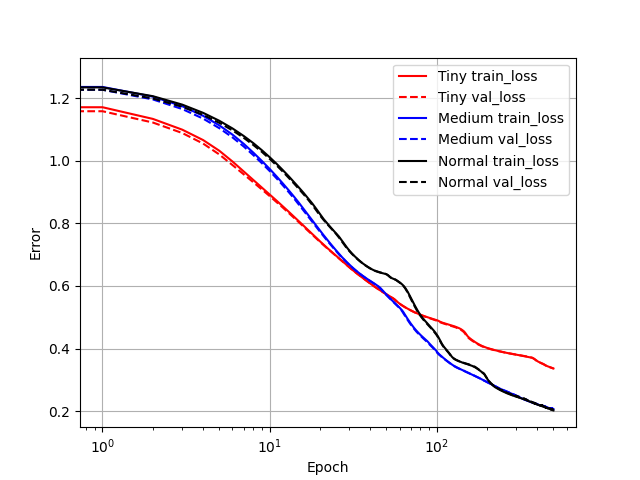

In [36]:
from scipy.interpolate import make_interp_spline

max_epochs=500

x = np.linspace(0,max_epochs,max_epochs)

Tiny_train_xy_spline = make_interp_spline(x, size_histories['Tiny'].history['loss'])
Tiny_valid_xy_spline = make_interp_spline(x, size_histories['Tiny'].history['val_loss'])

Tiny_train_X = np.linspace(x.min(), x.max(), max_epochs)
Tiny_train_Y = Tiny_train_xy_spline(Tiny_train_X)

Tiny_valid_X = np.linspace(x.min(), x.max(), max_epochs)
Tiny_valid_Y = Tiny_valid_xy_spline(Tiny_valid_X)

Medi_train_xy_spline = make_interp_spline(x, size_histories['Medium'].history['loss'])
Medi_valid_xy_spline = make_interp_spline(x, size_histories['Medium'].history['val_loss'])

Medi_train_X = np.linspace(x.min(), x.max(), max_epochs)
Medi_train_Y = Medi_train_xy_spline(Medi_train_X)

Medi_valid_X = np.linspace(x.min(), x.max(), max_epochs)
Medi_valid_Y = Medi_valid_xy_spline(Medi_valid_X)

x = np.linspace(0,len(size_histories['Normal'].history['loss']),len(size_histories['Normal'].history['loss']))

Norm_train_xy_spline = make_interp_spline(x, size_histories['Normal'].history['loss'])
Norm_valid_xy_spline = make_interp_spline(x, size_histories['Normal'].history['val_loss'])

Norm_train_X = np.linspace(x.min(), x.max(), max_epochs)
Norm_train_Y = Norm_train_xy_spline(Norm_train_X)

Norm_valid_X = np.linspace(x.min(), x.max(), max_epochs)
Norm_valid_Y = Norm_valid_xy_spline(Norm_valid_X)

#x = np.linspace(0,len(size_histories['Large'].history['loss']),len(size_histories['Large'].history['loss']))

#Larg_train_xy_spline = make_interp_spline(x, size_histories['Large'].history['loss'])
#Larg_valid_xy_spline = make_interp_spline(x, size_histories['Large'].history['val_loss'])

#Larg_train_X = np.linspace(x.min(), x.max(), 2000)
#Larg_train_Y = Larg_train_xy_spline(Larg_train_X)

#Larg_valid_X = np.linspace(x.min(), x.max(), 2000)
#Larg_valid_Y = Larg_valid_xy_spline(Larg_valid_X)

plt.figure()
plt.plot(Tiny_train_X, Tiny_train_Y, 'r', label='Tiny train_loss', )
plt.plot(Tiny_valid_X, Tiny_valid_Y,'r--', label='Tiny val_loss')
plt.plot(Medi_train_X, Medi_train_Y, 'b', label='Medium train_loss')
plt.plot(Medi_valid_X, Medi_valid_Y, 'b--', label='Medium val_loss')
plt.plot(Norm_train_X, Norm_train_Y, 'k', label='Normal train_loss')
plt.plot(Norm_valid_X, Norm_valid_Y, 'k--', label='Normal val_loss')
#plt.plot(Larg_train_X, Larg_train_Y, 'g', label='Large loss')
#plt.plot(Larg_valid_X, Larg_valid_Y, 'g--', label='Large val_loss')
plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

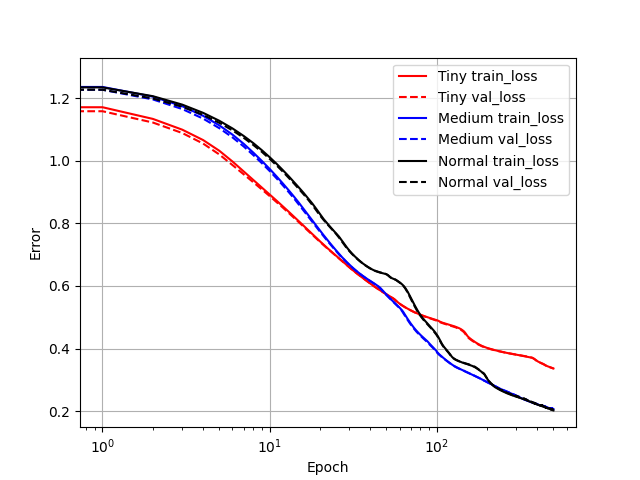

In [38]:
from scipy.interpolate import make_interp_spline

x = np.linspace(0,max_epochs,max_epochs)

Tiny_train_xy_spline = make_interp_spline(x, size_histories['Tiny'].history['loss'])
Tiny_valid_xy_spline = make_interp_spline(x, size_histories['Tiny'].history['val_loss'])

Tiny_train_X = np.linspace(x.min(), x.max(), max_epochs)
Tiny_train_Y = Tiny_train_xy_spline(Tiny_train_X)

Tiny_valid_X = np.linspace(x.min(), x.max(), max_epochs)
Tiny_valid_Y = Tiny_valid_xy_spline(Tiny_valid_X)

plt.figure()
plt.plot(Tiny_train_X, Tiny_train_Y, 'r', label='Tiny train_loss', )
plt.plot(Tiny_valid_X, Tiny_valid_Y,'r--', label='Tiny val_loss')
plt.plot(Medi_train_X, Medi_train_Y, 'b', label='Medium train_loss')
plt.plot(Medi_valid_X, Medi_valid_Y, 'b--', label='Medium val_loss')
plt.plot(Norm_train_X, Norm_train_Y, 'k', label='Normal train_loss')
plt.plot(Norm_valid_X, Norm_valid_Y, 'k--', label='Normal val_loss')
#plt.plot(Larg_train_X, Larg_train_Y, 'g', label='Large loss')
#plt.plot(Larg_valid_X, Larg_valid_Y, 'g--', label='Large val_loss')
plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)